#**LSTM**
The problem we are trying to solve here is to classify variable sized sequences of drawings into 10 categories (apple, banana, fork...). 

We are tackling this problem with an LSTM (Long-Short Memory Network). The input of the LSTM are the keypoints of the drawings in the order in which they were drawn.

The dataset we will use is extracted from the Kaggle competition: **Quick Draw! Doodle Recognition Challenge ** (https://www.kaggle.com/c/quickdraw-doodle-recognition). This dataset contains 

#**1. Notebook Setting**

Import Pytorch and Python libraries (Numpy, Matplotlib...)

In [10]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  
import numpy as np
import os
import sys
import torch
import torchvision
import random
import codecs
import torch.utils.data
import torch.optim as optim
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms

print('Done!')

Done!


In [47]:
#Training on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda:0
Sun Dec 16 12:22:40 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    72W / 149W |    437MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|

# **2. Dataset Preparation**

Download, reduce, reshape and reorganize dataset


## **2.1 Download the Dataset:**

The dataset is downloaded from Google Drive and it comes in the form of a csv files with the sequences. The link is public.

In [42]:
  !pip install googledrivedownloader
  
  from google_drive_downloader import GoogleDriveDownloader as gdd
  urls = [
        '1JmW1jzvcDCSRg2vr6nBfmnWyR2K665Ny', 
        '1_DRuC1dnG6Rsfb-a32eXD0fh_dpyiuJU',
        '1cBXEmlIAwuOmwPEgd9kbnSvjofGEFIAU',
        '1OZdyx5rXytzXnvTq8S3LZS_Ewl_iyIio',
        '1585P-SU8G_vNGu78yEJhOpH9-ajxz3fm',
        '1a9KvLtNi3crhi3iqBX93UwKlmPlmxnyi',
        '1lnneEBuc2K4papzkui14ZiYN58dMM8VZ',
        '1KdDex8cjZc-SNR8NVURsK-OaXtfxEskU',
        '1fODQI_9LtXyXVk9RNGC7VWZxUlsahxKk',
        '1hbRfukgoLJoQeGtjL820cR89hEqBkzk4'
    ]
  
  class_name = ['apple', 'banana', 'book', 'fork', 'key', 'ladder', 'pizza', 'stop_sign', 'tennis_racquet', 'wheel']

    
  def createDir(path):
    if not os.path.exists(path):
        os.makedirs(path)
  extension = '.csv'
                  
  for i in range(0, len(urls)):
    createDir('data')
    name = class_name[i] + extension
    gdd.download_file_from_google_drive(file_id = urls[i],
                                       dest_path = os.path.join('data', name))
    
    
  print("Done!")   

Done!


## **2.2 Reduction, reshape and reorganization of the Dataset:**

We selected 10 classes from the original datset, which was composed by more than 300 classes. 
For each drawing, we have a **variable sized** sequence that contains the ordered keypoints of the drawings. By keypoints we mean the important points in a drawing to define its structure (see point 2.3 Dataset Visualization for more information). We will get these keypoints from the csv file and save them to a folder (train, validation and test) in a ".npy" format. 

We can specify how many samples of each class we want for each class, in this case 10.000. When we run this cell, we will have 10.000 samples/class proportionally distributed taking into account the percen array. By default: 6.000 samples/class for training, 3.000 samples/class for validation and 1.000 samples/class for testing.

In [43]:
import pandas as pd
import json

class_name = ['apple', 'banana', 'book', 'fork', 'key', 'ladder', 'pizza', 'stop_sign', 'tennis_racquet', 'wheel']
step = ['train', 'validation', 'test']

dire = r'data/'

max_length = 10000 # Maximum number of files (drawings) per class
percen=[0.6, 0.3, 0.1] # Percentage of training, validation and testing

begin = [0, int(max_length * percen[0]), int(max_length * (percen[0] + percen[1]))]
end = [int(max_length * (percen[0])), int(max_length * (percen[0] + percen[1])), max_length-10]
print(begin)
print(end)
for c in range(0, len(class_name)):
  print('Class ' + str(c+1) + ' out of ' + str(len(class_name)))
  filename = dire + str(class_name[c]) + '.csv'
  
  csv = pd.read_csv(filename, sep = ',')
  drawing = csv[csv['recognized']==True]
  drawings = csv['drawing']
  drawings = drawings.values
  data = drawings
  
  for s in range(0, len(step)):
    dire_step = str(dire) + str(step[s])
    if not os.path.exists(dire_step):
      os.makedirs(dire_step)
    
    for i in range(begin[s], end[s]):
      dire_class = str(dire_step) + '/' + str(class_name[c])
      if not os.path.exists(dire_class):
        os.makedirs(dire_class)
        
       
      x = np.array(json.loads(drawings[i]))
      drawing_strokes = []
      for elem in x:
        mat = np.zeros((2, len(elem[0])))
        mat[0, :] = elem[0][:]
        mat[1, :] = elem[1][:]
        drawing_strokes.append(mat)
      aux = np.zeros((2,1)) 
      for stroke in drawing_strokes:
        aux = np.hstack((aux, stroke))
      sample_name = class_name[c] + '_' + str(step[s]) + '_' + str(i)
      
      np.save(os.path.join(dire_class, sample_name), aux[:, 1:])

print('Done!')

[0, 6000, 9000]
[6000, 9000, 9990]
Class 1 out of 10
Class 2 out of 10
Class 3 out of 10
Class 4 out of 10
Class 5 out of 10
Class 6 out of 10
Class 7 out of 10
Class 8 out of 10
Class 9 out of 10
Class 10 out of 10
Done!


## **2.3 Dataset Visualization:**

Let us draw the keypoints of a random drawing of an apple. The number next to each keypoint is the order in which this keypoint was drawn. 

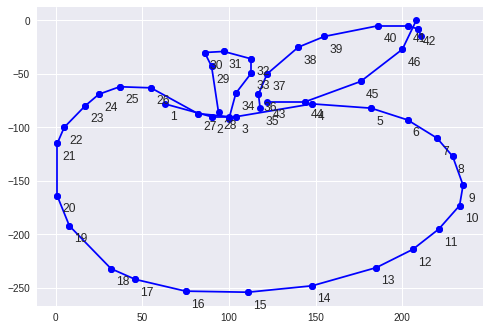

In [72]:
csv = pd.read_csv('data/apple.csv', sep = ',',engine = 'python')

# Header Format
#['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word'] 

drawing = csv[csv['recognized']==True]
drawings = csv['drawing']
drawings = drawings.values
index = 100000

x = np.array(json.loads(drawings[index]))
j = 0
for elem in x:
  for i in range(0,len(elem[0])-1):
    plt.plot([elem[0][i], elem[0][i+1]], [-elem[1][i], -elem[1][i+1]], marker = 'o', color = 'b')	
    j += 1
    plt.text(elem[0][i]+3, -elem[1][i] -15, str(j)) # The +3 and -15

plt.show()

# **3. Data Loading**

In this section we define the data loaders and the auxiliary classes that make possible loading sequences of different lenghts.

## **3.1  Auxiliary classes to get variable sized sequences**

We have the data organized in folders. We have a folder for the training data, a folder for the validation data, and a folder for the test data. For example, for the training data, we have 10 folders, one for each class, each one containing the training samples in the ".npy" format. This can be seen running the following commands, the first one shows the structure of the training folder and the second one counts the number of files in the data/training/apple directory.




In [25]:
!ls data/train
!ls -l data/train/apple | egrep -c '^-'

apple  banana  book  fork  key	ladder	pizza  stop_sign  tennis_racquet  wheel
6000


Having this structure, we can take advantage of the PyTorch class [DatasetFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#datasetfolder). This class creates a datasetFolder object that **understands every folder in the root directory as a different class**, and inside every folder of each class it expects to find all the samples of that class. These samples can be in the extension that we want, in our case: ".npy".  

However, we need more things than a DatasetFolder object in order to load batches automatically while training our network, and we need ***even more*** things if our data is variable-sized. 

Let us go step by step. Once the DatasetFolder object is created, we need an object that **gets the data from that Dataset automatically**, that object is called [DataLoader](https://pytorch.org/docs/0.4.0/data.html#torch.utils.data.DataLoader ). The DataLoader is created taking as argument the DatasetFolder object so it knows where to get the data and how to get it. In addition, and here is where the variable-sized sequences come into play, **we can define a method that preprocess our data before building a batch and pass it as argument!** To do that, we create a class called PadCollate that deals with this problem. 

This class will take a batch of different length sequences, it will compute the length of all of them, and finally it will zero-pad all the sequences in decreasing length. That is, if we have a batch of 4 sequences with lengths {3, 4, 6, 10}, we will end with a batch of 4 sequences of length 10. We want to preserve the length of the sequence, otherwise, the LSTM won't be able to freeze its hidden layers when the padded zeros are passed as input (it will just take the important part of the input sequences). 


In [0]:
def pad_tensor(my_vec, my_pad, my_dim):
    """
    args:
        my_vec - tensor to my_pad
        my_pad - the size to my_pad to
        my_dim - my_dimension to my_pad

    return:
        a new tensor my_padded to 'my_pad' in my_dimension 'my_dim'
    """
    my_pad_size = list(my_vec.shape)
    my_pad_size[my_dim] = my_pad - my_vec.size(my_dim)
    return torch.cat([my_vec, torch.zeros(*my_pad_size).double()], dim=my_dim)

class PadCollate:
	"""
	a variant of collate_fn that pads according to the longest sequence in
	a batch of sequences
	"""
	def __init__(self, dim=0):
		"""
		args:
		dim - the dimension to be padded (dimension of time in sequences)
		"""
		self.dim = dim


	def pad_collate(self, batch):

		# find longest sequence
		lengths = np.flip(np.sort([x[0].shape[self.dim] for x in batch]), axis = 0)
		max_len = max(map(lambda x: x[0].shape[self.dim], batch))
		batch = list(map(lambda x: (pad_tensor(x[0], my_pad=max_len, my_dim=self.dim), x[1]), batch))
		# stack all
		xs = torch.stack(list(map(lambda x: x[0], batch)), dim=1)
		ys = torch.tensor(list(map(lambda x: x[1], batch)))
		return xs, ys, lengths

	def __call__(self, batch):
		return self.pad_collate(batch)


## **3.2 Data Loaders definition**

In the cell below we define our DatasetFolder objects and the corresponding DataLoaders associated to each DatasetFolder. Notice that to handle the variable-sized sequences we must pass as argument a method that pads the sequence with zeros.

We also define our batch size (here called **bs**), since the DataLoader needs to know how many samples it has to get for each batch.

In [0]:
def load_sample(x):
  """
  We have to tell to the DatasetFolder object HOW TO load a single example so it can form batches with a few samples each one.
  """
  # We load them in format N x 2 in order to stack them in proper order
  return torch.from_numpy(np.load(x).T).double()

# BATCH SIZE
bs = 30

# DatasetFolder creation and DataLoader creation
train_dir = r"data/train"
val_dir = r"data/validation"
test_dir = r"data/test"

train_dataset = datasets.DatasetFolder(train_dir, extensions = ['.npy'], loader = load_sample)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = bs, shuffle = True, num_workers = 0, collate_fn = PadCollate(dim=0))
train_iter = iter(train_loader)

valid_dataset = datasets.DatasetFolder(val_dir, extensions = ['.npy'], loader = load_sample)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = bs, shuffle = True, num_workers = 0, collate_fn = PadCollate(dim = 0))
valid_iter = iter(valid_loader)

test_dataset = datasets.DatasetFolder(test_dir, extensions = ['.npy'], loader = load_sample)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = bs, shuffle = True, num_workers = 0, collate_fn = PadCollate(dim = 0))
test_iter = iter(test_loader)

To check that the resulting batch has the expected size, we load one single batch.

In [29]:
samples, labels, lengths = valid_iter.next() 
print("The size of the batch is:")
print(samples.size())
print("The size of the labels is:")
print(labels.size())
print("The size of the length is:")
print(np.shape(lengths))

The size of the batch is:
torch.Size([108, 30, 2])
The size of the labels is:
torch.Size([30])
The size of the length is:
(30,)


# 4. Model definition and training

Now that we have our dataset structured in folders, our dataloaders that get batches automatically, it is time to build the model! 

The model that we are going to train is an LSTM (Long-Short Term Memory Network). 

First of all, we must consider the sizes of the tensors that the network is going to take as input. Recalling the previous information about the batch size and the batch padding explained in section 3, we have:

1.   Sequences of  ** * x 2** , where ** * ** is the length of the sequence,  **which is variable**, and ** 2 ** is given by the keypoints in the drawing, which have a range between (0, 0) and (255, 255).


2.   We pad this sequences with zeros according to the longest sequence length. Thus, we end with a batch of padded sequence that will have the size: ** LONGEST_LENGTH x BATCH_SIZE x 2** 


Having explained the input to our network, we have to build our LSTM network. Since we are solving a classification problem, we will need a fully connected layer on top of the LSTM in order to classify the extracted features coming from the LSTM hidden layer.

A very important point in the cell below is **how we are passing the padded batch to our model**. If we look at the forward pass method, it needs to know the lengths of the padded sequence in order to not take these padded values as valid inputs. Then, thanks to the PyTorch method [pack_padded_sequence](https://pytorch.org/docs/0.3.1/nn.html#torch.nn.utils.rnn.pack_padded_sequence) we can forward pass the batch to the network safely.

Another important point is that if we look at the forward method in the cell below, it has not a softmax layer at the end. The reason is because we are using [CrossEntropyLoss](https://pytorch.org/docs/0.3.1/nn.html#torch.nn.CrossEntropyLoss) class and it computes the softmax for us. 

In [0]:
class Quick_draw_LSTM(nn.Module):
  def __init__(self, lstm_input_size, lstm_units, lstm_hidden_units, batch_size, output_dim):
    super(Quick_draw_LSTM, self).__init__()
    self.lstm_input_size = lstm_input_size
    # Number of stacked lstm that we will have 
    self.lstm_units = lstm_units
    # Number of hidden units of each LSTM
    self.lstm_hidden_units = lstm_hidden_units
    self.batch_size = batch_size
    self.output_dim = output_dim
    self.__build_model()
  
  def __build_model(self):
    self.lstm = nn.LSTM(input_size = self.lstm_input_size, hidden_size = self.lstm_hidden_units,num_layers = self.lstm_units)
    self.hidden_to_class = nn.Linear(self.lstm_hidden_units, self.output_dim)
    
  def init_hidden(self):
    hidden_a = torch.zeros(self.lstm_units, self.batch_size, self.lstm_hidden_units)
    hidden_b = torch.zeros(self.lstm_units, self.batch_size, self.lstm_hidden_units)
    return (hidden_a.to(device), hidden_b.to(device))
  
  def forward(self, X, X_lengths):
    # at the beginning of each sequence we must reset the hidden states
    self.hidden = self.init_hidden()
    seq_len, batch_size, features_size = X.size()
    """We pack the batch with pack_padded_sequence, this method is useful because the LSTM won't see
    the padded values. This function expects as arguments: a tensor of (T x B x *)
    """
    X = nn.utils.rnn.pack_padded_sequence(X, X_lengths)
    # Forward pass through the LSTM
    X, self.hidden = self.lstm(X, self.hidden)
    # Unpack the padded sequence
    X = nn.utils.rnn.pad_packed_sequence(X)
    X = X[0].contiguous()
    X = X.view(-1, X.shape[2])
    X = self.hidden_to_class(X)
    
    #X = F.log_softmax(X, dim=1) #If we use crossEntropy loss it computes the softmax for us!!
    X = X.view(seq_len, batch_size, self.output_dim)
    return X

# **4. Network Training**

In [31]:

model = Quick_draw_LSTM(2, 3, 512, bs, 10)
model.to(device)

Quick_draw_LSTM(
  (lstm): LSTM(2, 512, num_layers=3)
  (hidden_to_class): Linear(in_features=512, out_features=10, bias=True)
)

In [0]:
!mkdir saved_model5

In [0]:
#In these lists we save the loss and accuracy to plot them afterwards
training_loss_list = []
validation_loss_list = []
training_accuracy_list = []
validation_accuracy_list = []

# Optimization Hyper-parameters
epochs = 150
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(epochs):
  
  running_loss = 0.0
  training_accuracy = 0.0
  training_total = 0.0
  training_correct = 0.0
  
  for i, data in enumerate(train_loader, 0):
    model.train()
    # Sample a batch. Recall that we need the lengths for the padding and packing!
    inputs, labels, lengths = data
   
    inputs = inputs.float().to(device)
    labels = labels.to(device)
    lengths = torch.from_numpy(lengths.copy()).to(device)
    
    # Zero the gradients because pytorch accumulates gradients
    optimizer.zero_grad()
    # Forward pass
    outputs = model(inputs, lengths)
   
    # We take only the last output of each sequence! Valid outputs are the outputs computed in the sequence's lengths
    valid_outputs = outputs[np.array(lengths-1), np.arange(0, bs), :]
    
    # Get the indices of the maximum predicted values
    _, predicted = torch.max(valid_outputs.data, 1)
    # Get the number of correct predictions to compute the accuracy afterwards
    training_total = training_total + labels.size(0)
    training_correct = training_correct + (predicted == labels).sum().item()
    
    # Compute the cross entropy loss
    loss = criterion(valid_outputs, labels)
    
    # Backward pass and parameters update
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    # Print loss information after 200 batches/epoch
    if i % 200 == 199:
      training_accuracy = training_correct/training_total
      print('[%d, %5d] loss: %.3f - Training_Accuracy: %.3f' % (epoch + 1, i + 1, running_loss / 200, training_accuracy))
      training_loss_list.append(running_loss)
      training_accuracy_list.append(training_accuracy)
      running_loss = 0.0
      training_total = 0.0
      training_correct = 0.0 
      
  with torch.no_grad():

    validation_correct = 0.0
    validation_accuracy = 0.0
    validation_total = 0.0
    running_validation_loss = 0.0
    
    model.eval()
    
    for j, valid_data in enumerate(valid_loader, 0):
      validation_inputs, validation_labels, validation_lengths = valid_data
      
      validation_inputs = validation_inputs.float().to(device)
      validation_labels = validation_labels.to(device)
      validation_lengths = torch.from_numpy(validation_lengths.copy()).to(device)
      validation_outputs = model(validation_inputs, validation_lengths)

      validation_valid_outputs = validation_outputs[np.array(validation_lengths-1), np.arange(0, bs), :]

      valid_loss = criterion(validation_valid_outputs, validation_labels)
      _, val_predicted = torch.max(validation_valid_outputs.data, 1)
      validation_total = validation_labels.size(0) + validation_total
      validation_correct = (val_predicted == validation_labels).sum().item() + validation_correct
      running_validation_loss += valid_loss.item()

    validation_accuracy = validation_correct/validation_total
    print('[%d, %5d] Validation loss: %.3f - Validation_Accuracy: %.3f' %(epoch + 1, i + 1, running_validation_loss/(len(valid_loader)), validation_accuracy))
    validation_loss_list.append(running_validation_loss/len(valid_loader))
    validation_accuracy_list.append(validation_accuracy)
    val_correct = 0.0
    running_validation_loss = 0.0
  #Save the model for early-stopping
  torch.save(model.state_dict(), os.path.join('saved_model5', str(epoch)))
  state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
  }
  torch.save(state, os.path.join('saved_model', str("to_retrain_")+str(epoch))

[1,   200] loss: 2.229 - Training_Accuracy: 0.161
[1,   400] loss: 2.126 - Training_Accuracy: 0.194
[1,   600] loss: 2.040 - Training_Accuracy: 0.225
[1,   800] loss: 1.959 - Training_Accuracy: 0.271
[1,  1000] loss: 1.897 - Training_Accuracy: 0.296
[1,  1200] loss: 1.793 - Training_Accuracy: 0.337
[1,  1400] loss: 1.764 - Training_Accuracy: 0.350
[1,  1600] loss: 1.781 - Training_Accuracy: 0.357
[1,  1800] loss: 2.015 - Training_Accuracy: 0.268
[1,  2000] loss: 1.847 - Training_Accuracy: 0.331
[1,  2000] Validation loss: 1.754 - Validation_Accuracy: 0.357
[2,   200] loss: 1.966 - Training_Accuracy: 0.284
[2,   400] loss: 1.895 - Training_Accuracy: 0.299
[2,   600] loss: 1.788 - Training_Accuracy: 0.345
[2,   800] loss: 1.716 - Training_Accuracy: 0.380
[2,  1000] loss: 1.656 - Training_Accuracy: 0.411
[2,  1200] loss: 1.551 - Training_Accuracy: 0.453
[2,  1400] loss: 1.467 - Training_Accuracy: 0.482
[2,  1600] loss: 1.434 - Training_Accuracy: 0.492
[2,  1800] loss: 1.390 - Training_Acc

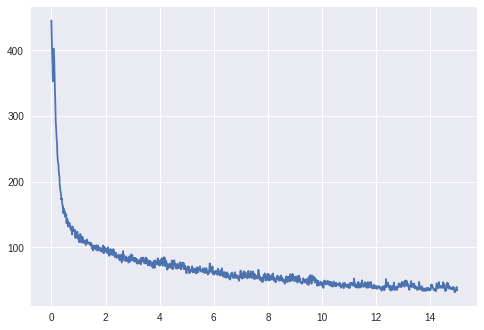

In [0]:
import numpy as np
import matplotlib.pyplot as plt

training_examples = 6e5
plot_every = 200 # We plot loss information after 200 forward passes
training_loss_np = np.asarray(training_loss_list)
#validation_loss_np = np.asarray(validation_loss_list)

x_axis = np.arange(0, len(training_loss_list))
plt.plot(x_axis * bs * plot_every / training_examples, training_loss_np)
#plt.plot(x_axis * bs * plot_every / training_ex, validation_loss_np)
plt.show()

In [0]:
from google.colab import files
files.download('example.txt') 

In [0]:
!ls

sample_data


# **5. Network Testing**

In [32]:
model.load_state_dict(torch.load('51'))
model.eval()

Quick_draw_LSTM(
  (lstm): LSTM(2, 512, num_layers=3)
  (hidden_to_class): Linear(in_features=512, out_features=10, bias=True)
)

In [46]:
running_test_loss=0.0
test_total=0.0
test_correct=0.0
criterion = nn.CrossEntropyLoss()
for i, test_data in enumerate(test_loader,0): 
  test_inputs, test_labels, test_lengths = test_data
  
  test_inputs = test_inputs.float().to(device)
  test_labels = test_labels.to(device)
  test_lengths = torch.from_numpy(test_lengths.copy()).to(device)
  test_outputs = model(test_inputs, test_lengths)
  test_valid_outputs = test_outputs[np.array(test_lengths-1), np.arange(0, bs), :]
  
  test_loss = criterion(test_valid_outputs, test_labels)
  running_test_loss += test_loss.item()
  
  _,predicted = torch.max(test_valid_outputs.data,1)
  test_total = test_total+test_labels.size(0)
  test_correct = test_correct + (predicted == test_labels).sum().item()        
  
test_accuracy = test_correct/test_total
  
print('Test Loss: %.3f - Test Accuracy: %.3f' %
         (running_test_loss/len(test_loader), test_accuracy))

Test Loss: 0.426 - Test Accuracy: 0.854


Let's evaluate the model on the test data:

While our densely-connected network we had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we decreased our error rate by 68% (relative).

In [0]:
# ACCURACY OF THE NETWORK
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [0]:
#WHICH CLASSESS PERFORMED BETTER
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 51 to 51
User uploaded file "51" with length 21059362 bytes
